<a href="https://www.kaggle.com/code/wrecked22/fall-detection?scriptVersionId=241275853" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

def merge_csv_files_recursive(directory_path):
    merged_data = pd.DataFrame()

    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path)
                merged_data = pd.concat([merged_data, df], ignore_index=True)

    return merged_data

def normalize_features(dataset, features_to_normalize):
    
    scaler = MinMaxScaler()
    dataset[features_to_normalize] = scaler.fit_transform(dataset[features_to_normalize])
    
    return dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fall_dataset = merge_csv_files_recursive('/kaggle/input/anomaly-detection-falling-people-events/data/train/')
fall_dataset = fall_dataset[['x', 'y', 'z', 'anomaly']]

In [3]:
fall_dataset['anomaly'].value_counts()

0.0    127656
1.0      6573
Name: anomaly, dtype: int64

In [4]:
features_to_normalize = ['x', 'y', 'z']
normalized_data = normalize_features(fall_dataset, features_to_normalize)

class_0_data = normalized_data[normalized_data['anomaly'] == 0].sample(n=6000, random_state=42)
class_1_data = normalized_data[normalized_data['anomaly'] == 1]

balanced_data = pd.concat([class_0_data, class_1_data], axis=0).reset_index(drop=True)

In [5]:
fig = go.Figure(data=go.Scatter3d(
    x=balanced_data['x'],
    y=balanced_data['y'],
    z=balanced_data['z'],
    mode='markers',
    marker=dict(
        size=4,
        color=balanced_data['anomaly'].astype(int), 
        colorscale='RdBu', 
        opacity=0.1
    )
))

fig.update_layout(scene=dict(
    xaxis_title='X-axis',
    yaxis_title='Y-axis',
    zaxis_title='Z-axis'
))

fig.show()

# Approach 1. Tackle as a Binary Classification Problem

In [6]:

import os
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

warnings.filterwarnings('ignore', category=UserWarning)

class_0_data = normalized_data[normalized_data['anomaly'] == 0.0].sample(n=6000, random_state=42)
class_1_data = normalized_data[normalized_data['anomaly'] == 1.0]
balanced_data = pd.concat([class_0_data, class_1_data]).sample(frac=1, random_state=42).reset_index(drop=True)

# Features and target from the balanced dataset
X = balanced_data[['x', 'y', 'z']]
y = balanced_data['anomaly']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifiers = [
    ('SVC', SVC(), {
        'C': Real(1, 10, prior='log-uniform'),
        'kernel': Categorical(['linear']) 
    }),
    ('LightGBM', LGBMClassifier(), {
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(3, 10)
    }),
    ('KNN', KNeighborsClassifier(), {
        'n_neighbors': Integer(3, 15)
    }),
    ('Logistic Regression', LogisticRegression(solver='saga', max_iter=5000), {
        'C': Real(1e-2, 1e2, prior='log-uniform'),
        'penalty': Categorical(['l1', 'l2'])
    })
]

results = {}

# Perform Bayesian Search
for name, model, search_space in classifiers:
    print(f"\nRunning Bayesian Optimization for {name}...")
    bayes_search = BayesSearchCV(
        estimator=model,
        search_spaces=search_space,
        n_iter=10,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        random_state=42
    )
    bayes_search.fit(X_train, y_train)
    results[name] = bayes_search

# Display results
for name, bayes_search in results.items():
    print(f"\nResults for {name}:")
    print(f"Best parameters: {bayes_search.best_params_}")
    print(f"Best cross-validated accuracy: {bayes_search.best_score_:.4f}")

# Evaluate on test set
print("\nTest Set Evaluation:")
for name, bayes_search in results.items():
    y_pred = bayes_search.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Running Bayesian Optimization for SVC...


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



Running Bayesian Optimization for LightGBM...

Running Bayesian Optimization for KNN...

Running Bayesian Optimization for Logistic Regression...

Results for SVC:
Best parameters: OrderedDict([('C', 5.42035858064384), ('kernel', 'linear')])
Best cross-validated accuracy: 0.6904

Results for LightGBM:
Best parameters: OrderedDict([('learning_rate', 0.17502718999472844), ('max_depth', 8), ('n_estimators', 274)])
Best cross-validated accuracy: 0.8977

Results for KNN:
Best parameters: OrderedDict([('n_neighbors', 3)])
Best cross-validated accuracy: 0.9120

Results for Logistic Regression:
Best parameters: OrderedDict([('C', 0.4369339947510315), ('penalty', 'l2')])
Best cross-validated accuracy: 0.6821

Test Set Evaluation:

SVC Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.66      0.67      1200
         1.0       0.70      0.71      0.70      1315

    accuracy                           0.69      2515
   macro avg       0.6

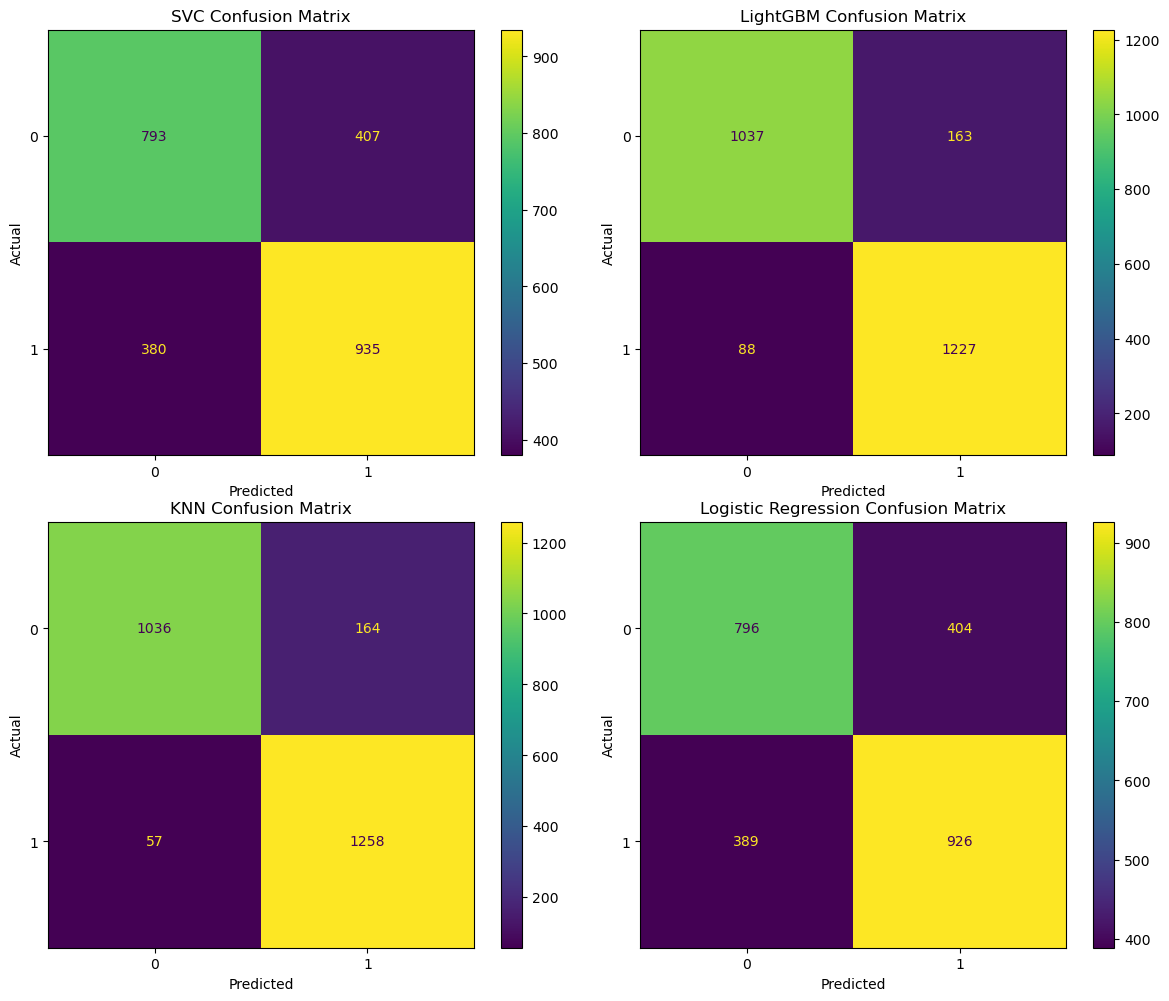

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Create a 2x2 subplot for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Loop through classifiers and plot confusion matrices
for idx, (name, bayes_search) in enumerate(results.items()):
    y_pred = bayes_search.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], values_format='d')
    axes[idx].set_title(f"{name} Confusion Matrix")
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

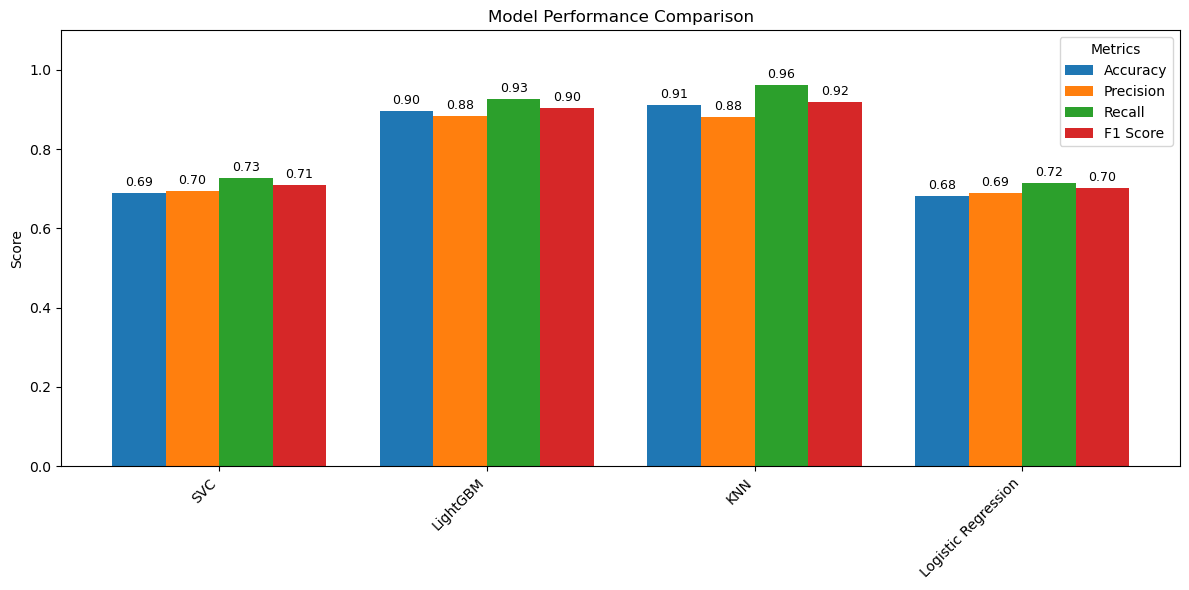

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Step 1: Define scoring dictionary
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

# Step 2: Evaluate models and collect metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
model_names = []

for name, bayes_search in results.items():
    model = bayes_search.best_estimator_
    scores = cross_validate(
        model, X_train, y_train,
        scoring=scoring, cv=5, n_jobs=-1
    )
    model_names.append(name)
    accuracies.append(np.mean(scores['test_accuracy']))
    precisions.append(np.mean(scores['test_precision']))
    recalls.append(np.mean(scores['test_recall']))
    f1_scores.append(np.mean(scores['test_f1']))

# Step 3: Create dictionary of metrics
metrics_dict = {
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
}

# Step 4: Plot grouped bar chart
metric_names = list(metrics_dict.keys())
num_models = len(model_names)
num_metrics = len(metric_names)
bar_width = 0.2
x = np.arange(num_models)

fig, ax = plt.subplots(figsize=(12, 6))

for i, metric in enumerate(metric_names):
    bar_positions = x + i * bar_width
    values = metrics_dict[metric]

    bars = ax.bar(bar_positions, values, width=bar_width, label=metric)

    # Add numbers on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=9
        )

# Formatting
ax.set_xticks(x + bar_width * (num_metrics - 1) / 2)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1.1)
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.legend(title="Metrics")

plt.tight_layout()
plt.show()

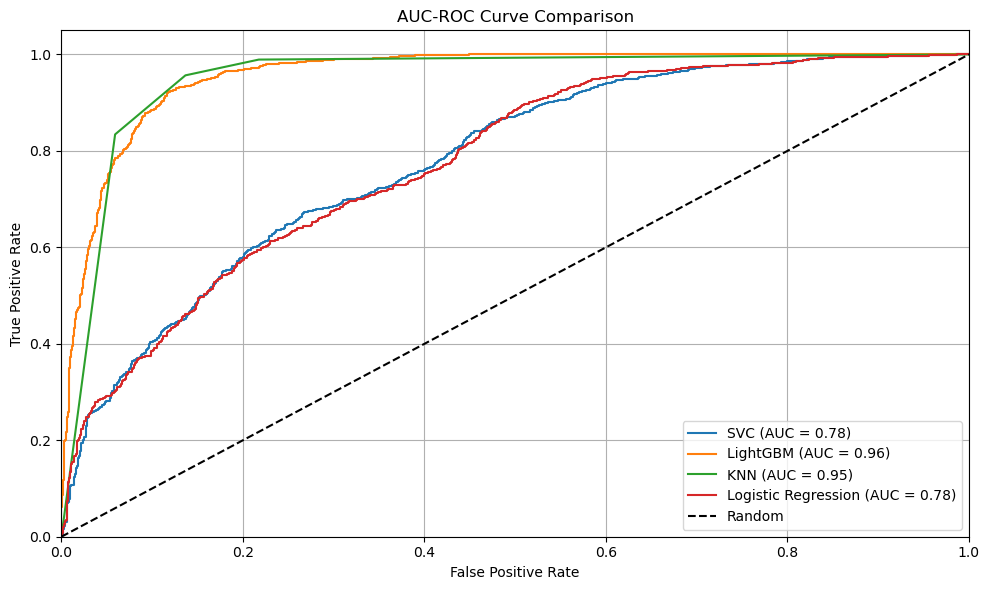

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plotting ROC curves for all models
plt.figure(figsize=(10, 6))

for name, bayes_search in results.items():
    model = bayes_search.best_estimator_

    # Some models like SVC may not have predict_proba, use decision_function
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Approach 2. Tackle as an Anomaly Detection Problem

In [10]:
normalized_data['anomaly'].value_counts()

0.0    127656
1.0      6573
Name: anomaly, dtype: int64

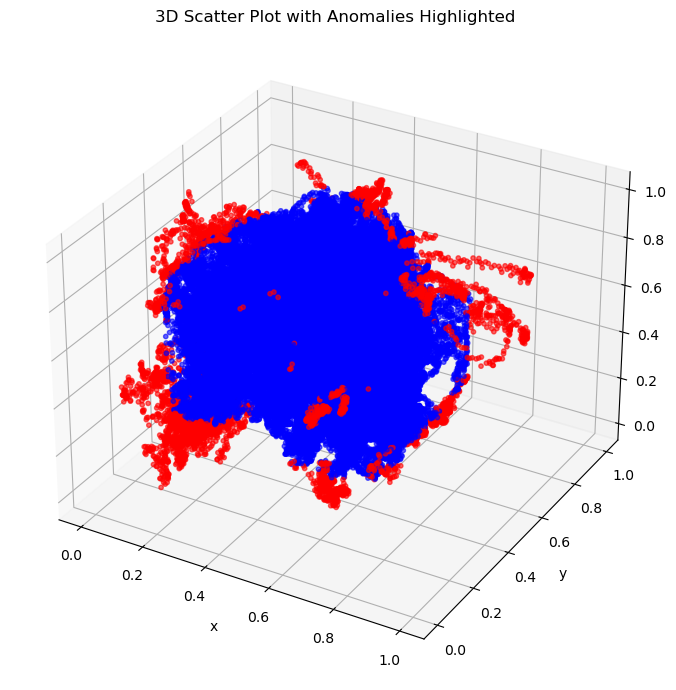

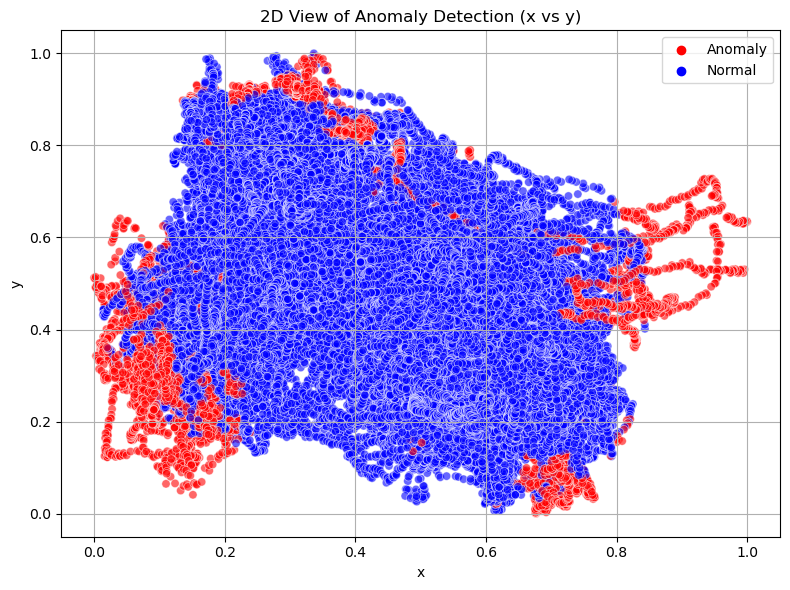

In [11]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Use only the feature columns
X = normalized_data[['x', 'y', 'z']]

# Step 2: Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X)

# Step 3: Get anomaly scores and labels
normalized_data['anomaly_score'] = iso_forest.decision_function(X)  # the lower, the more abnormal
normalized_data['anomaly_flag'] = iso_forest.predict(X)  # -1 = anomaly, 1 = normal

# Convert flags to readable format (optional)
normalized_data['anomaly_flag'] = normalized_data['anomaly_flag'].map({1: 'Normal', -1: 'Anomaly'})

# Step 4: Visualize anomalies

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = ['red' if label == 'Anomaly' else 'blue' for label in normalized_data['anomaly_flag']]

ax.scatter(
    normalized_data['x'],
    normalized_data['y'],
    normalized_data['z'],
    c=colors,
    alpha=0.6,
    s=10
)
ax.set_title("3D Scatter Plot with Anomalies Highlighted")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.tight_layout()
plt.show()

# Optional 2D projection
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=normalized_data,
    x='x',
    y='y',
    hue='anomaly_flag',
    palette={'Normal': 'blue', 'Anomaly': 'red'},
    alpha=0.6
)
plt.title("2D View of Anomaly Detection (x vs y)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter3d(
    x=normalized_data['x'],
    y=normalized_data['y'],
    z=normalized_data['z'],
    mode='markers',
    marker=dict(
        size=4,
        color=(normalized_data['anomaly_flag'] == 'Anomaly').astype(int),  # 1 for anomalies
        colorscale='RdBu',  # Blue (normal) → Red (anomaly)
        opacity=0.5,
        colorbar=dict(title="Anomaly")
    )
))

fig.update_layout(
    title="3D Scatter Plot of Predicted Anomalies",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()